In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import pandas as pd

from pathlib import Path
import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
sys.path.append(os.path.join(ipynb_dir, '..'))  # Needed for import below

from sc2sensor.dataset import SensorCIFAR10
from sc2sensor.dataset import LABELS_DICT, DEFAULT_10, ID_TO_RACE, MAP_NAME_TO_ID
from sc2sensor.utils.image_utils import imshow


root = os.path.join(ipynb_dir, '..', 'data')
subdir = 'starcraft-sensor-dataset'
model_root_dir = Path('models')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Map + Binary  (Begining/End game)

In [4]:
# grab the first 5 maps
SUBMAP_NAMES_TO_ID = {name: 2*mid if mid <= 4 else None for name, mid in MAP_NAME_TO_ID.items()}

# Label func
def map_plus_begin_end_game(smd):
    # Input is single metadata row as pandas row
    # Output is target_label (e.g., string) and target_id (e.g., 0-9)
    map_id = SUBMAP_NAMES_TO_ID[smd['static.game_info.map_name']]
    is_end = (smd['dynamic.window_idx'] / smd['dynamic.num_windows']) > 0.5
    if map_id is not None:
        target_id = map_id + is_end  # int + True == int + 1 and int + False == int
        target_label = (smd['static.game_info.map_name'], 'End' if is_end else 'Begining')
    else:
        target_id = pd.NA
        target_label = pd.NA

    return target_label, target_id

    
# Probably takes forever right now because it's add target_labels/ids to every row 
#  (can do this before caching metadata for efficiency)
dataset = SensorCIFAR10(root, subdir=subdir, train=False, label_func=map_plus_begin_end_game, 
                        use_cache=False, transform=transforms.ToTensor()) 

Using cached CSV metadata
Post-processing metadata
Finished dataset init


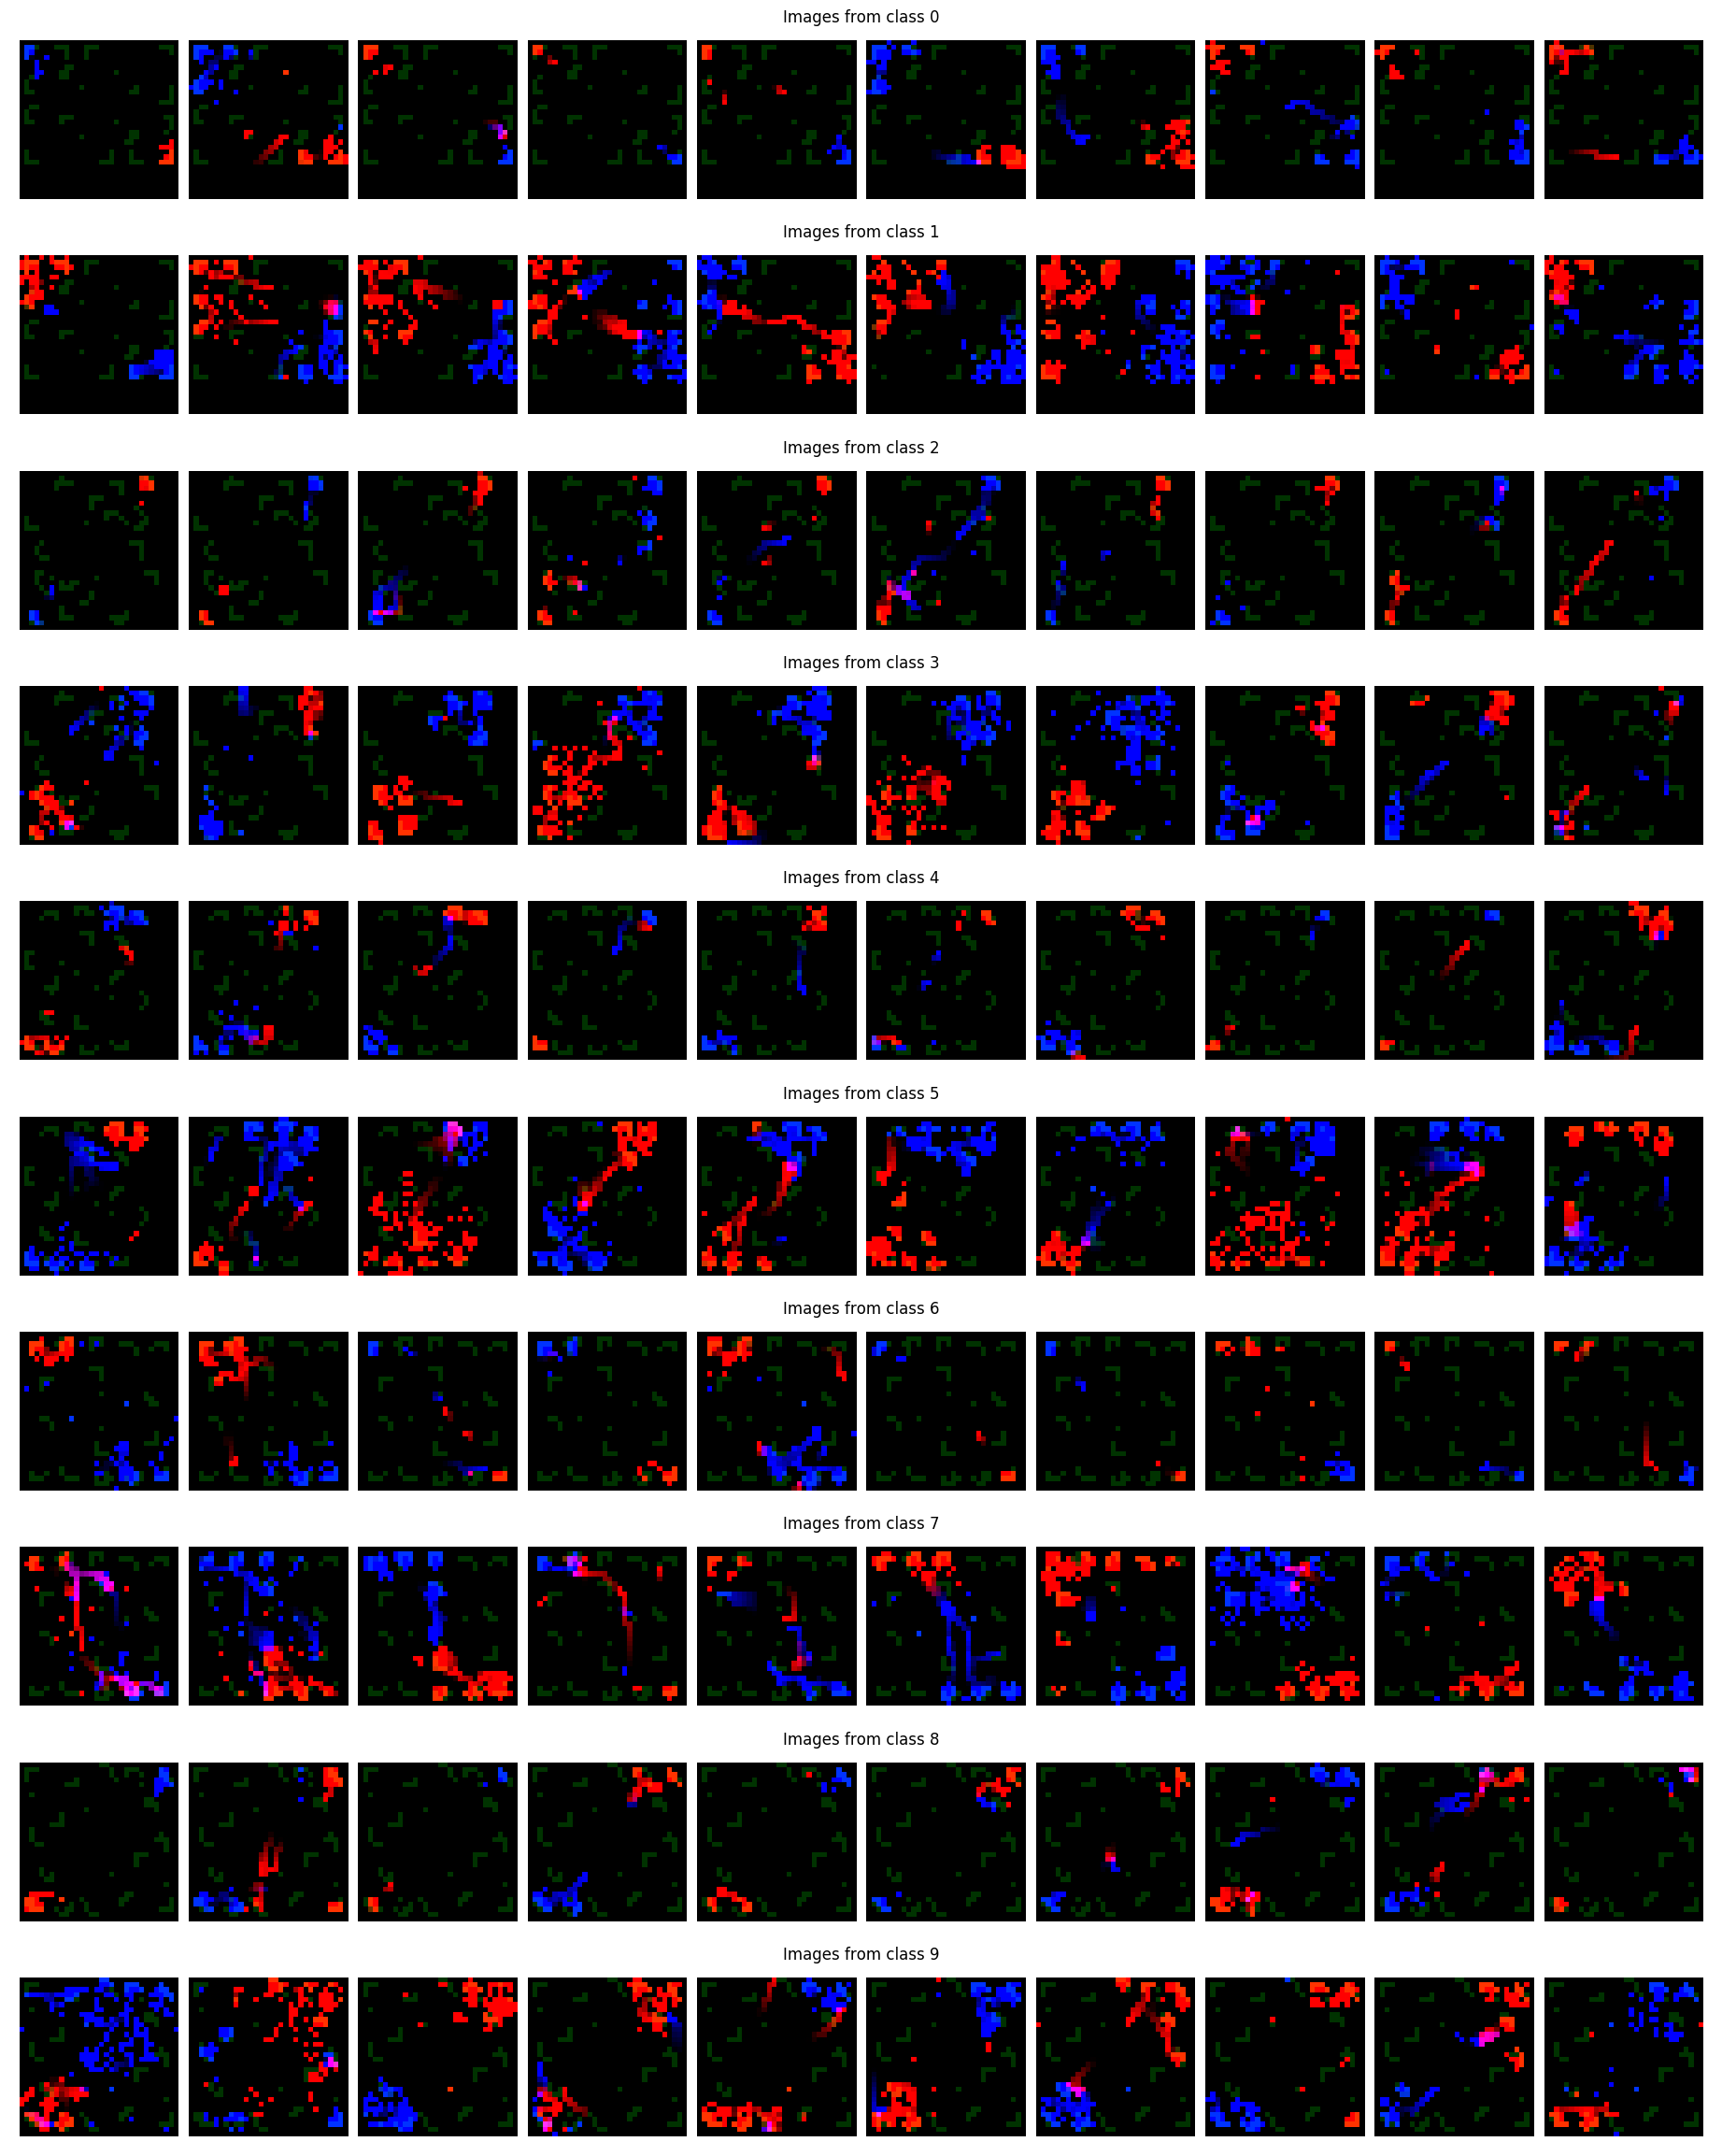

In [5]:
import matplotlib.pyplot as plt
n_classes = 10
n_show = 10 

dataloader = torch.utils.data.DataLoader(dataset, batch_size=n_show*n_classes*2, shuffle=False)
batch = next(iter(dataloader))

fig, axes = plt.subplots(n_classes, 1, figsize=np.array([n_show*6, n_classes*6])*0.5, dpi=100)
for yy, ax in enumerate(axes):
    im_grid = torchvision.utils.make_grid([x for x, y in zip(batch[0], batch[1]) if y==yy][:n_show], nrow=n_show, pad_value=1)
    imshow(im_grid, title=f'Images from class {yy}', ax=ax)
    ax.grid(False)
    ax.set_axis_off()

In [6]:
import matplotlib.pyplot as plt
n_classes = 10
n_show = 30 

dataloader = torch.utils.data.DataLoader(dataset, batch_size=n_show*n_classes*2, shuffle=False)
batch = next(iter(dataloader))

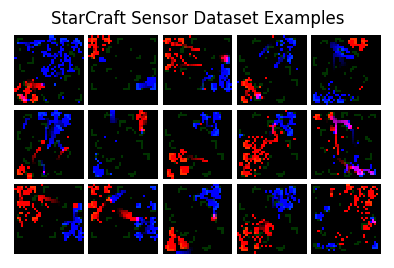

In [7]:
nrow = 3
n_per_row = 5
images = [x for x, y in zip(batch[0], batch[1]) if y%2==1]
im_grid = torchvision.utils.make_grid(images[:nrow*n_per_row], nrow=n_per_row, ncol=nrow, pad_value=1)
fig = plt.figure(figsize=np.array([n_per_row, nrow]), dpi=100)
ax = plt.gca()
imshow(im_grid, title=f'StarCraft Sensor Dataset Examples', ax=ax)
ax.grid(False)
ax.set_axis_off()

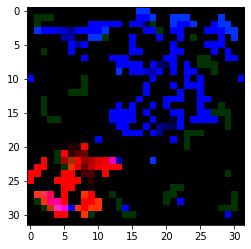

In [8]:
example_image = images[0]
imshow(example_image)

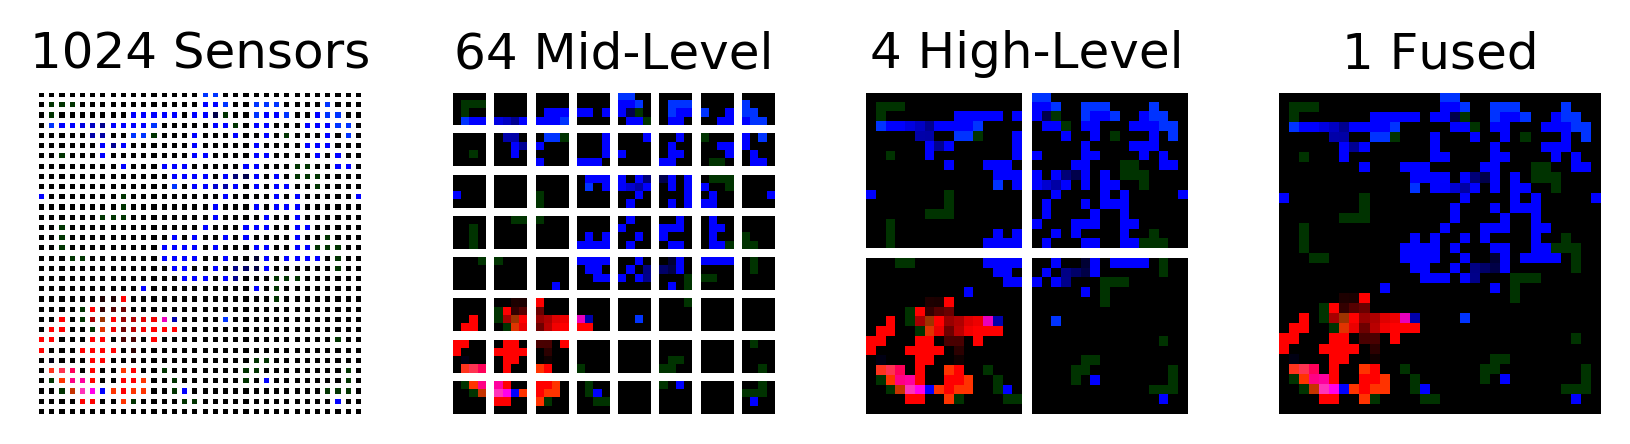

In [26]:
def extract_sensors(image, sensor_range):
    # R = sensor range
    # N = number of sensors
    C, H, W = image.shape
    sensors = F.unfold(
        image.unsqueeze(0), kernel_size=sensor_range, stride=sensor_range
    ).squeeze(0) # Shape: (3*R*R, N) 
    sensors = sensors.T #(N, 3*R*R)
    sensors = sensors.reshape(-1, 3, sensor_range, sensor_range)
    sensor_grid = torchvision.utils.make_grid(sensors, nrow=W//sensor_range, ncol=H//sensor_range, pad_value=1, padding=1)
    return sensors, sensor_grid

torch.manual_seed(0)
nr, nc = 1, 4
fig, axes = plt.subplots(nr, nc, figsize=np.array([nc*2.8, nr*3])*0.5, dpi=300)
axi = iter(axes.ravel())


for ii, sensor_range in enumerate([1, 4, 16, 32]):
    sensors, sensor_grid = extract_sensors(example_image, sensor_range)
    if ii != 3:
        sensor_grid = sensor_grid[:, 1:-1, 1:-1] # clip off padding on outside
    
    ax = next(axi)
    imshow(sensor_grid, ax=ax)
    ax.grid(False)
    ax.set_axis_off()
    if ii == 0:
        ax.set_title(f'{32*32/sensor_range/sensor_range:.0f} Sensors')
    elif ii == 1:
        ax.set_title(f'{32*32/sensor_range/sensor_range:.0f} Mid-Level')
    elif ii == 2:
        ax.set_title(f'{32*32/sensor_range/sensor_range:.0f} High-Level')
    elif ii == 3:
        ax.set_title(f'{32*32/sensor_range/sensor_range:.0f} Fused')
fig.tight_layout()

In [47]:
def create_irregular_network(image, n_sensors, average_radius=2, layout='regular', radius_kind='equal', 
                             base_value=1, failures=0):
    C, H, W = image.shape
    nW = int(torch.sqrt(torch.tensor(n_sensors)).floor())
    nH = int(n_sensors/nW)
    assert n_sensors == nW*nH, 'Can only do n_sensors that is square'
    
    if radius_kind == 'equal': 
        radius_arr = average_radius * torch.ones(n_sensors)
    elif radius_kind == 'random':
        concentration = 5.0 # "shape" parameter of Gamma
        # average = concentration * rate
        rate = concentration / average_radius  # Rate is inverse_scale
        radius_dist = torch.distributions.Gamma(torch.tensor(concentration), torch.tensor(rate))
        radius_arr = radius_dist.sample([n_sensors])
    else:
        raise ValueError('radius_kind unknown')
    
    loc_dist = torch.distributions.Uniform(0, 1)
    if layout == 'regular' or layout == 'semi-regular':
        xx = torch.linspace(0, W, steps=nW+1)[:nW]
        space = xx[1] - xx[0]
        yy = torch.linspace(0, H, steps=nH+1)[:nH]
        xx, yy = torch.meshgrid(xx, yy, indexing='ij')
        # Location + centering shift + noise
        loc_arr = torch.stack((xx.ravel(), yy.ravel())).T + (space+1)/2 - 1 
        if layout == 'semi-regular':
            # Add noise
            loc_arr += (space/2)*(loc_dist.sample([n_sensors, 2])-0.5)
    elif layout == 'irregular':
        loc_arr = loc_dist.sample([n_sensors, 2]) * torch.tensor([H, W])
    else:
        raise ValueError('layout unknown')
        
    new_image = base_value * np.ones_like(image)
    # Slow for loop implementation
    failed = list(np.random.RandomState(0).randint(0, len(radius_arr), size=(failures,)))
    for ii, (r, loc) in enumerate(zip(radius_arr, loc_arr)):
        if ii in failed:
            continue # Skip failed sensors
        for i in range(H):
            for j in range(W):
                cur = torch.tensor([i, j])
                dist = ((cur - loc)**2).sum().sqrt() 
                if dist <= r:
                    new_image[:, i, j] = image[:, i, j]  #  Make visible
                    
    return new_image
        
    

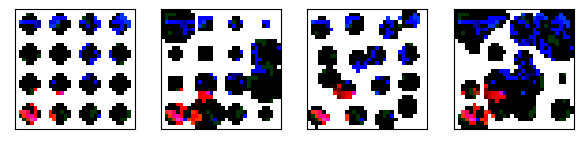

In [29]:
torch.manual_seed(0)
nr, nc = 1, 4
fig, axes = plt.subplots(nr, nc, figsize=np.array([nc*3, nr*3])*0.5, dpi=100)
axi = iter(axes.ravel())

irregular_networks = [
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='regular', radius_kind='equal'),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='regular', radius_kind='random'),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='semi-regular', radius_kind='equal'),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='semi-regular', radius_kind='random'),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
]
for ii, irr_image in enumerate(irregular_networks):
    ax = next(axi)
    imshow(irr_image, ax=ax)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_axis_off()
    if False:
        if ii == 0:
            ax.set_title('Same Radius')
            ax.set_ylabel('Regular Grid', fontsize=14)
        elif ii == 1:
            ax.set_title('Rand. Radius')
        elif ii == 2:
            ax.set_ylabel('Irreg. Grid', fontsize=14)
fig.tight_layout()

AttributeError: module 'numpy' has no attribute 'randi'

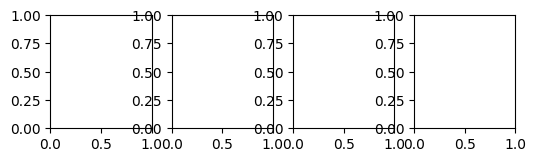

In [39]:
torch.manual_seed(0)
nr, nc = 1, 4
fig, axes = plt.subplots(nr, nc, figsize=np.array([nc*3, nr*3])*0.5, dpi=100)
axi = iter(axes.ravel())

irregular_networks = [
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='regular', radius_kind='equal', base_value=0),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='regular', radius_kind='random', base_value=0),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='semi-regular', radius_kind='equal', base_value=0),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='semi-regular', radius_kind='random', base_value=0),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
]
for ii, irr_image in enumerate(irregular_networks):
    ax = next(axi)
    imshow(irr_image, ax=ax)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_axis_off()
    if False:
        if ii == 0:
            ax.set_title('Same Radius')
            ax.set_ylabel('Regular Grid', fontsize=14)
        elif ii == 1:
            ax.set_title('Rand. Radius')
        elif ii == 2:
            ax.set_ylabel('Irreg. Grid', fontsize=14)
fig.tight_layout()

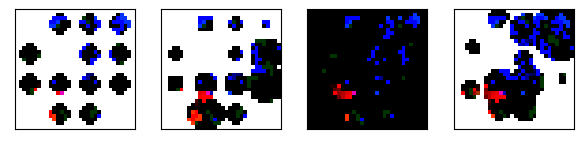

In [49]:
torch.manual_seed(0)
nr, nc = 1, 4
fig, axes = plt.subplots(nr, nc, figsize=np.array([nc*3, nr*3])*0.5, dpi=100)
axi = iter(axes.ravel())

irregular_networks = [
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='regular', radius_kind='equal', failures=4),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='regular', radius_kind='random', failures=4),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='semi-regular', radius_kind='equal', failures=4),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='semi-regular', radius_kind='random', failures=4),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
]
for ii, irr_image in enumerate(irregular_networks):
    ax = next(axi)
    imshow(irr_image, ax=ax)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_axis_off()
    if False:
        if ii == 0:
            ax.set_title('Same Radius')
            ax.set_ylabel('Regular Grid', fontsize=14)
        elif ii == 1:
            ax.set_title('Rand. Radius')
        elif ii == 2:
            ax.set_ylabel('Irreg. Grid', fontsize=14)
fig.tight_layout()

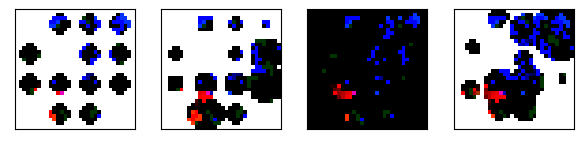

In [50]:
torch.manual_seed(0)
nr, nc = 1, 4
fig, axes = plt.subplots(nr, nc, figsize=np.array([nc*3, nr*3])*0.5, dpi=100)
axi = iter(axes.ravel())

irregular_networks = [
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='regular', radius_kind='equal', failures=4),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='regular', radius_kind='random', failures=4),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=2.8, layout='semi-regular', radius_kind='equal', failures=4, base_value=0),
    create_irregular_network(example_image, n_sensors=4**2, average_radius=3, layout='semi-regular', radius_kind='random', failures=4),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
    #create_irregular_network(example_image, n_sensors=5**2, average_radius=2.7, layout='irregular', radius_kind='random'),
]
for ii, irr_image in enumerate(irregular_networks):
    ax = next(axi)
    imshow(irr_image, ax=ax)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_axis_off()
    if False:
        if ii == 0:
            ax.set_title('Same Radius')
            ax.set_ylabel('Regular Grid', fontsize=14)
        elif ii == 1:
            ax.set_title('Rand. Radius')
        elif ii == 2:
            ax.set_ylabel('Irreg. Grid', fontsize=14)
fig.tight_layout()